In [1]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [3]:
# get data
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
    tf.keras.utils.get_file(
        'maestro-v2.0.0-midi.zip',
        origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
        extract=True,
        cache_dir='.', cache_subdir='data',
    )

In [4]:
# dataset info 
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [5]:
# Inspect MIDI file 
sample_file = filenames[1]
print(sample_file)

pm = pretty_midi.PrettyMIDI(sample_file)
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)
display_audio(pm)


data/maestro-v2.0.0/2013/ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_2013_wav--2.midi


In [6]:
# Inspection of MIDI file 
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [7]:
# Get notes 
for i, note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=75, note_name=D#5, duration=0.0677
1: pitch=63, note_name=D#4, duration=0.0781
2: pitch=75, note_name=D#5, duration=0.0443
3: pitch=63, note_name=D#4, duration=0.0469
4: pitch=75, note_name=D#5, duration=0.0417
5: pitch=63, note_name=D#4, duration=0.0469
6: pitch=87, note_name=D#6, duration=0.0443
7: pitch=99, note_name=D#7, duration=0.0690
8: pitch=87, note_name=D#6, duration=0.0378
9: pitch=99, note_name=D#7, duration=0.0742


In [8]:
# Extract notes 
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,63,1.001302,1.079427,0.000000,0.078125
1,75,1.006510,1.074219,0.005208,0.067708
2,75,1.305990,1.350260,0.299479,0.044271
3,63,1.305990,1.352865,0.000000,0.046875
4,75,1.630208,1.671875,0.324219,0.041667


In [9]:
# Switch to note names 
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['D#4', 'D#5', 'D#5', 'D#4', 'D#5', 'D#4', 'D#7', 'D#6', 'D#7',
       'D#6'], dtype='<U3')

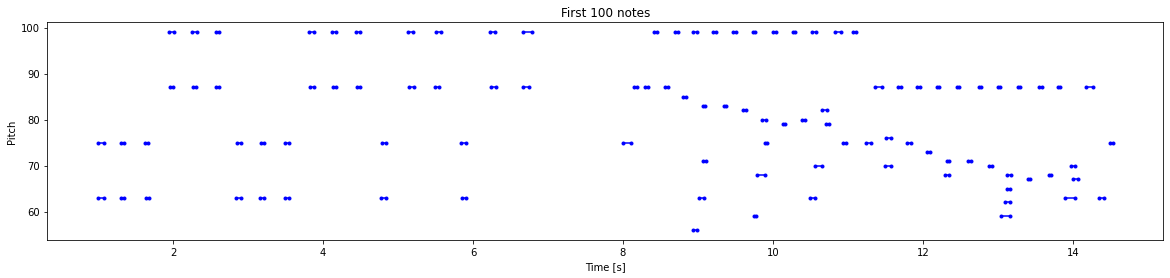

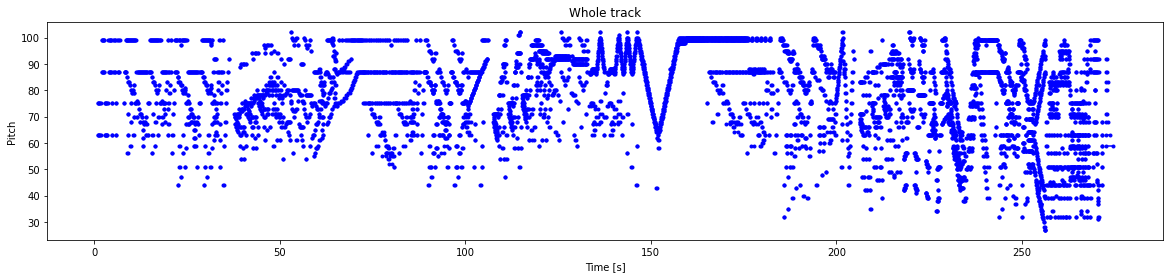

In [14]:
# Plot notes 
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)
plot_piano_roll(raw_notes, count=100)
plot_piano_roll(raw_notes)

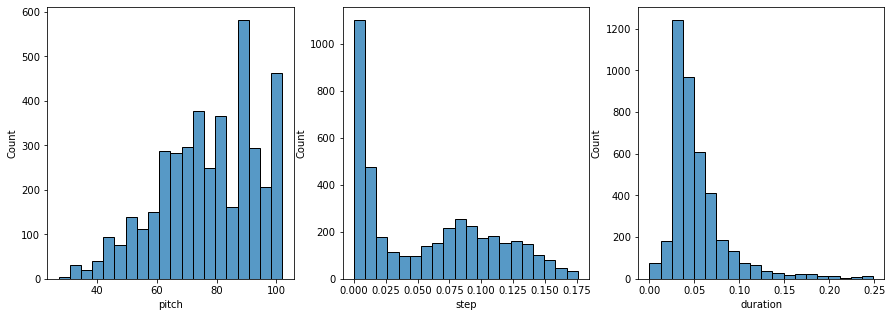

In [16]:
# View distribution of notes 
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 3, 1)
    sns.histplot(notes, x="pitch", bins=20)

    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))
plot_distributions(raw_notes)


In [17]:
# Notes to MIDI
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:
    
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

In [ ]:
# See if MIDI file is good 
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)
display_audio(example_pm)

# Preprocessing

In [22]:
# Create dataset 
num_files = 5
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
print(train_notes.shape)

# Create ds
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

Number of notes parsed: 15435
(15435, 3)


2022-07-18 10:13:36.167765: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [23]:
# Window function 
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
    """Returns TF Dataset of sequence and label examples."""
    seq_length = seq_length+1

    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalize note pitch
    def scale_pitch(x):
        x = x/[vocab_size,1.0,1.0]
        return x

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
# Create sequence 
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the ver

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [26]:
for seq, target in seq_ds.take(1):
    print('sequence shape:', seq.shape)
    print('sequence elements (first 10):', seq[0: 10])
    print()
    print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.6015625  0.         0.09244792]
 [0.3828125  0.00390625 0.40234375]
 [0.5703125  0.109375   0.06510417]
 [0.53125    0.09895833 0.06119792]
 [0.5703125  0.10807292 0.05989583]
 [0.4765625  0.06640625 0.05338542]
 [0.6015625  0.01302083 0.0703125 ]
 [0.5703125  0.11979167 0.07682292]
 [0.3984375  0.109375   0.43619792]
 [0.609375   0.00130208 0.09505208]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=54.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.005208333333333037>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.46875>}


In [28]:
# Batch dataset 
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

# Training

In [29]:
# Loss function (Mean squared error)
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [30]:
# Create Model 
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)
loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss=loss, optimizer=optimizer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [31]:
# Measure intial loss 
losses = model.evaluate(train_ds, return_dict=True)
losses

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

{'loss': 4.949057579040527,
 'duration_loss': 0.0648730918765068,
 'pitch_loss': 4.858096599578857,
 'step_loss': 0.026088548824191093}

In [33]:
# balance initial loss 
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)
model.evaluate(train_ds, return_dict=True)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
240/240 [==============================] - 2s 6ms/step - loss: 0.3339 - duration_loss: 0.0649 - pitch_loss: 4.8581 - step_loss: 0.0261


{'loss': 0.3338664174079895,
 'duration_loss': 0.0648730918765068,
 'pitch_loss': 4.858096599578857,
 'step_loss': 0.026088548824191093}

In [34]:
# Train 
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
240/240 [==============================] - 4s 12ms/step - loss: 0.2703 - duration_loss: 0.0471 - pitch_loss: 4.1075 - step_loss: 0.0178
Epoch 2/50
240/240 [==============================] - 3s 13ms/step - loss: 0.2523 - duration_loss: 0.0428 - pitch_loss: 3.8632 - step_loss: 0.0164
Epoch 3/50
240/240 [==============================] - 3s 12ms/step - loss: 0.2468 - 

240/240 [==============================] - 3s 14ms/step - loss: 0.1944 - duration_loss: 0.0247 - pitch_loss: 3.2341 - step_loss: 0.0079


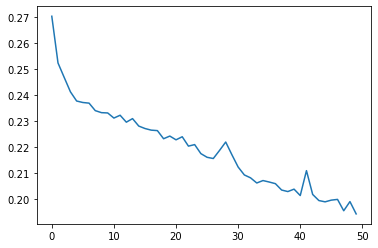

In [35]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

# Inference

In [37]:
# Get next note
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
    """Generates a note IDs using a trained sequence model."""

    assert temperature > 0

    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # `step` and `duration` values should be non-negative
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

In [38]:
# Get music
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 17ms/step


In [39]:
# view generate notes
generated_notes.head(10)

,pitch,step,duration,start,end
0,99,0.098859,0.130465,0.098859,0.229324
1,100,0.549495,0.376028,0.648354,1.024381
2,85,0.597805,0.316637,1.246159,1.562796
3,93,0.602799,0.310400,1.848958,2.159358
4,87,0.602114,0.311714,2.451072,2.762786
5,82,0.601354,0.312788,3.052425,3.365213
6,93,0.601366,0.318575,3.653791,3.972366
7,56,0.600349,0.315199,4.254140,4.569339
8,92,0.602977,0.322720,4.857117,5.179836
9,85,0.599778,0.307093,5.456895,5.763987


In [40]:
# Output
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)